In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, confusion_matrix


In [ ]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

# we separate the pixel values
train_images = train_data.iloc[:, 1:].values
# we get the label values
train_labels = train_data.iloc[:, 0].values

# same as above
test_images = test_data.iloc[:, 1:].values
test_labels = test_data.iloc[:, 0].values

# we convert the 784 pizels into images of 2d array of 28 x 28 pixels
train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)

# we normalize the images value to range 0 to 1 which helps in faster convergence
train_images = train_images / 255.0
test_images = test_images / 255.0

from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [ ]:
## defining the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

In [48]:
# to get the accuracy and loss
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')


313/313 - 2s - 5ms/step - accuracy: 0.8917 - loss: 0.3024
Test accuracy: 0.891700029373169
Test loss: 0.30243465304374695


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


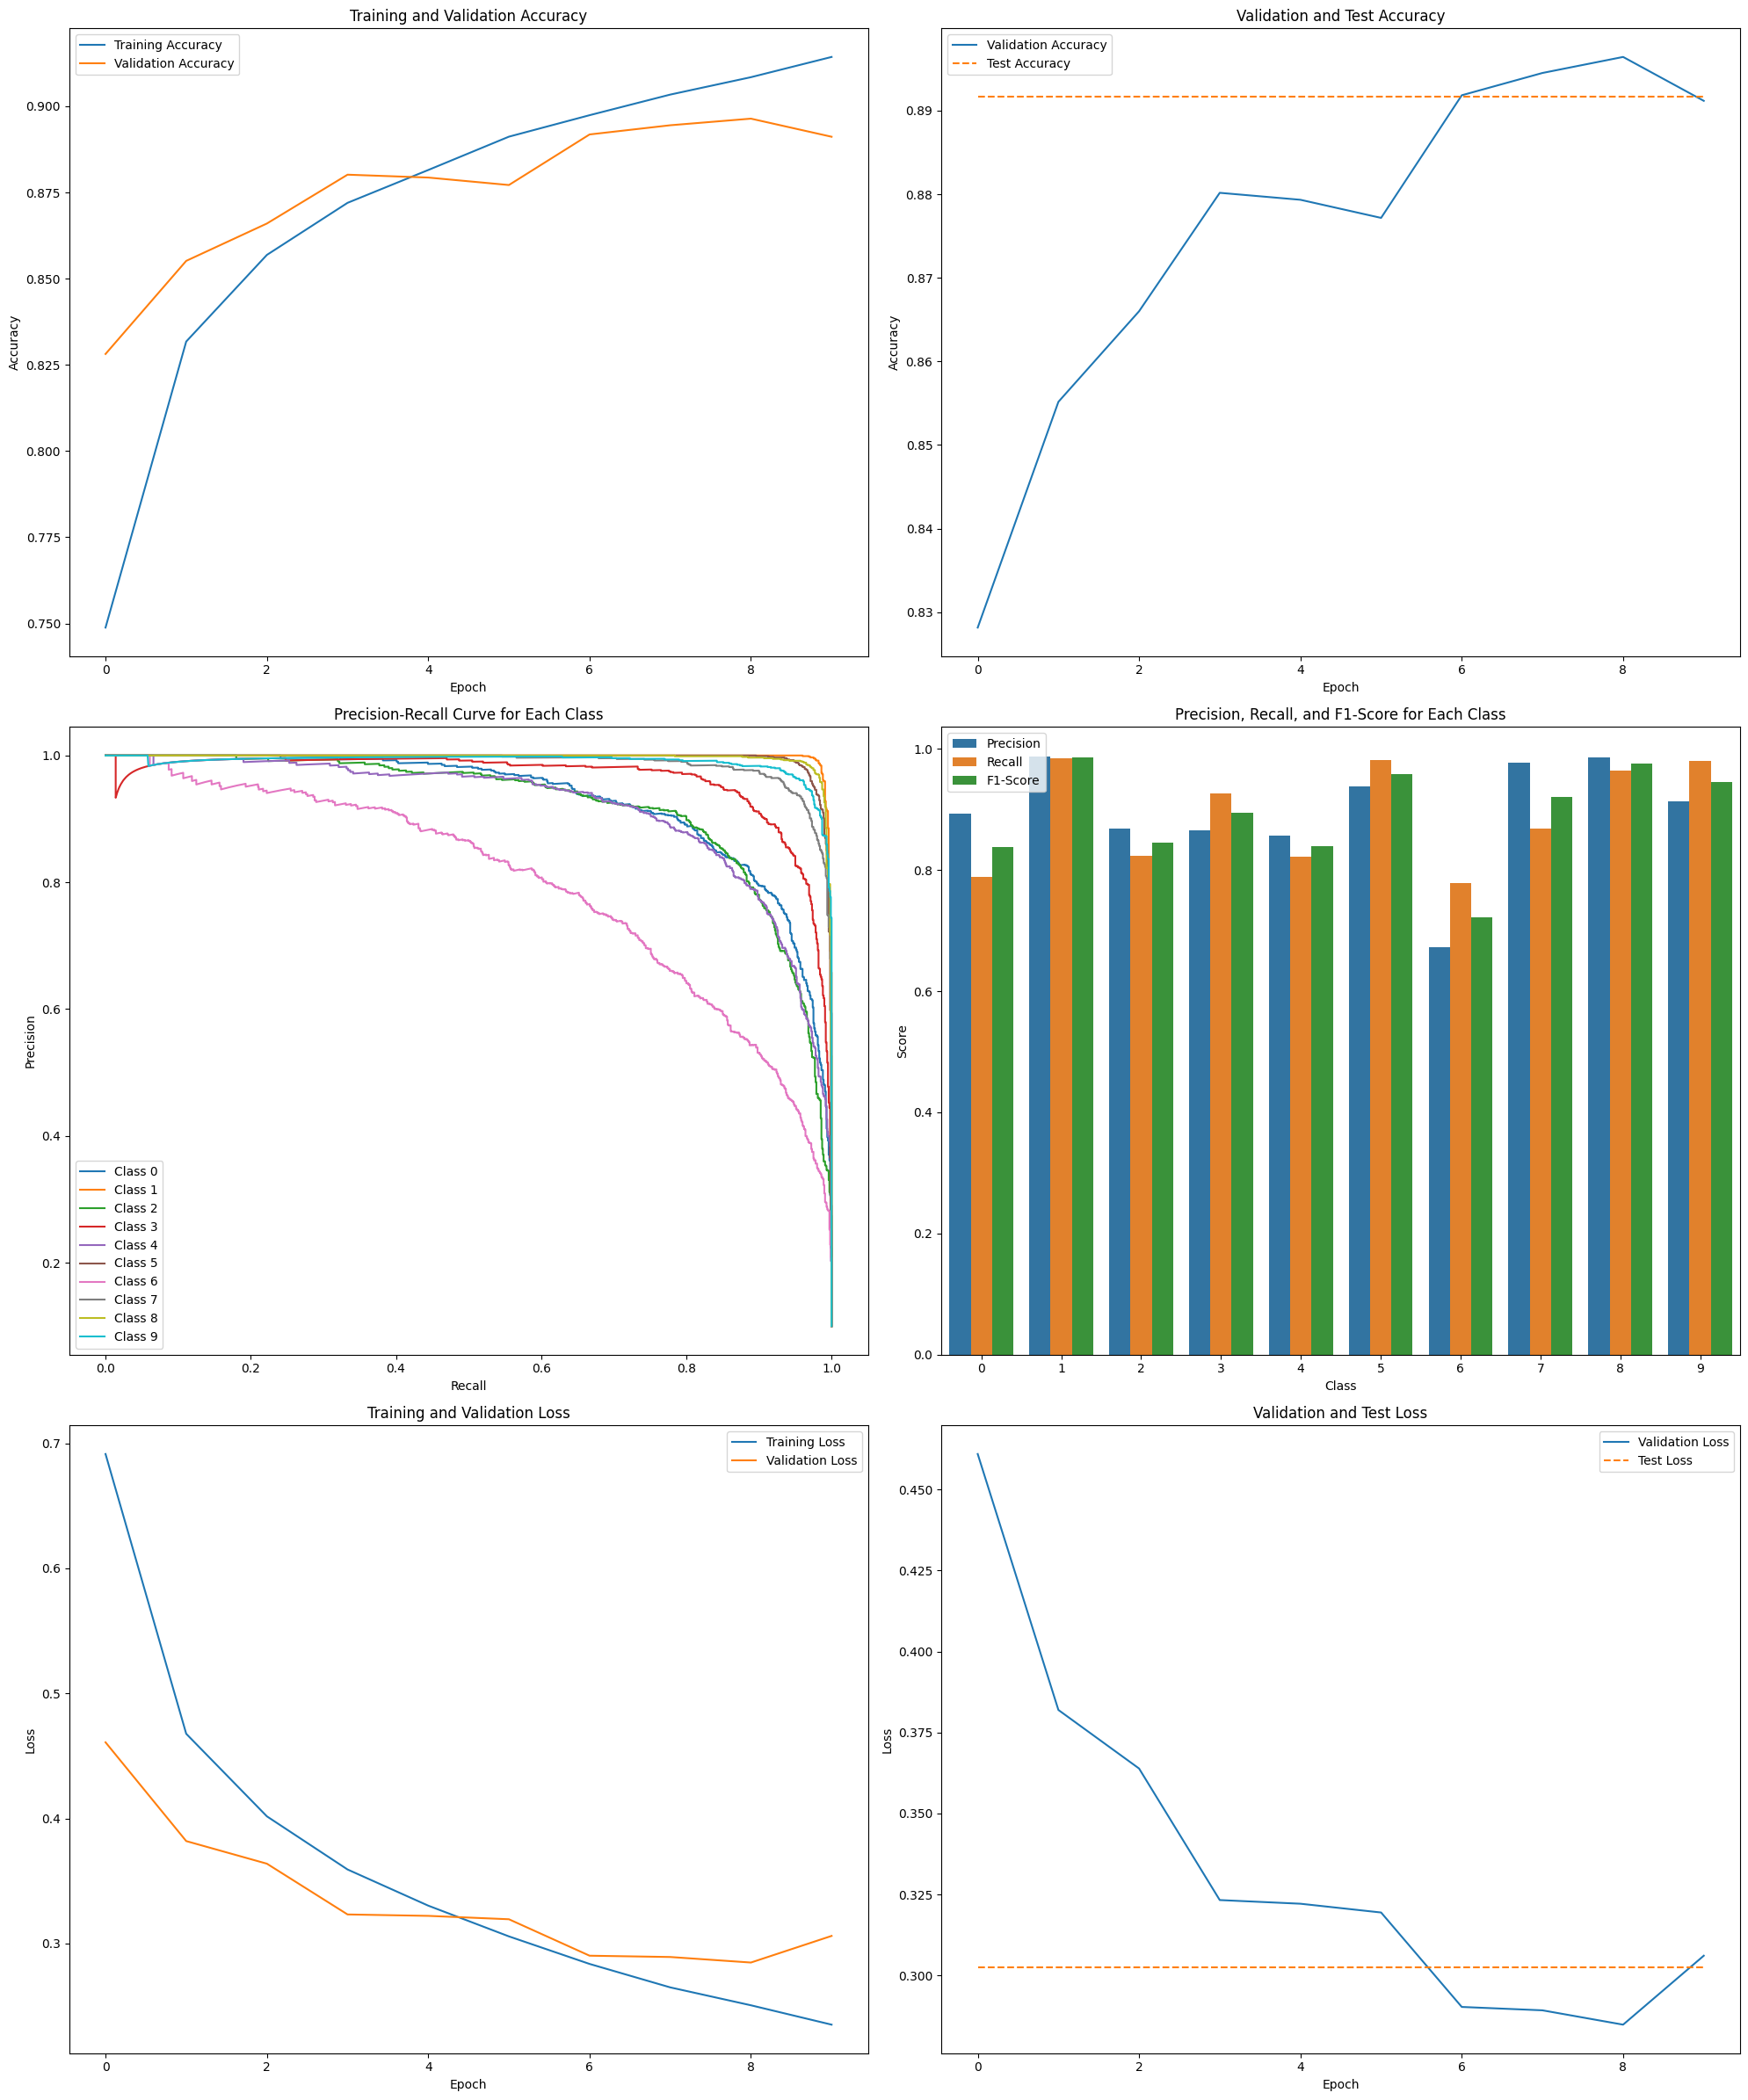

In [49]:
test_accuracies = []

for epoch in range(len(history.history['accuracy'])):
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
    test_accuracies.append(test_acc)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(3, 2, figsize=(20, 24))

#for Training and Validation Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Training and Validation Accuracy')
axes[0, 0].legend()

#for Validation and Test Accuracy
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].plot(test_accuracies, label='Test Accuracy', linestyle='--')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Validation and Test Accuracy')
axes[0, 1].legend()

# for Precision-Recall Curve for Each Class
for i in range(10): 
    precision_i, recall_i, _ = precision_recall_curve(test_labels == i, predictions[:, i])
    axes[1, 0].plot(recall_i, precision_i, label=f'Class {i}')
axes[1, 0].set_title('Precision-Recall Curve for Each Class')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend(loc='best')

# for Precision, Recall, and F1-Score for Each Class
precisions, recalls, f1_scores, _ = precision_recall_fscore_support(test_labels, predicted_labels)
scores_df = pd.DataFrame({
    'Class': range(10),
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})
scores_df = pd.melt(scores_df, id_vars=['Class'], value_vars=['Precision', 'Recall', 'F1-Score'])
sns.barplot(x='Class', y='value', hue='variable', data=scores_df, ax=axes[1, 1])
axes[1, 1].set_title('Precision, Recall, and F1-Score for Each Class')
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()

# for Training and Validation Loss
axes[2, 0].plot(history.history['loss'], label='Training Loss')
axes[2, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].set_title('Training and Validation Loss')
axes[2, 0].legend()

#for Validation and Test Loss
test_losses = []
for epoch in range(len(history.history['loss'])):
    test_loss, _ = model.evaluate(test_images, test_labels, verbose=0)
    test_losses.append(test_loss)

axes[2, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[2, 1].plot(test_losses, label='Test Loss', linestyle='--')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].set_title('Validation and Test Loss')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


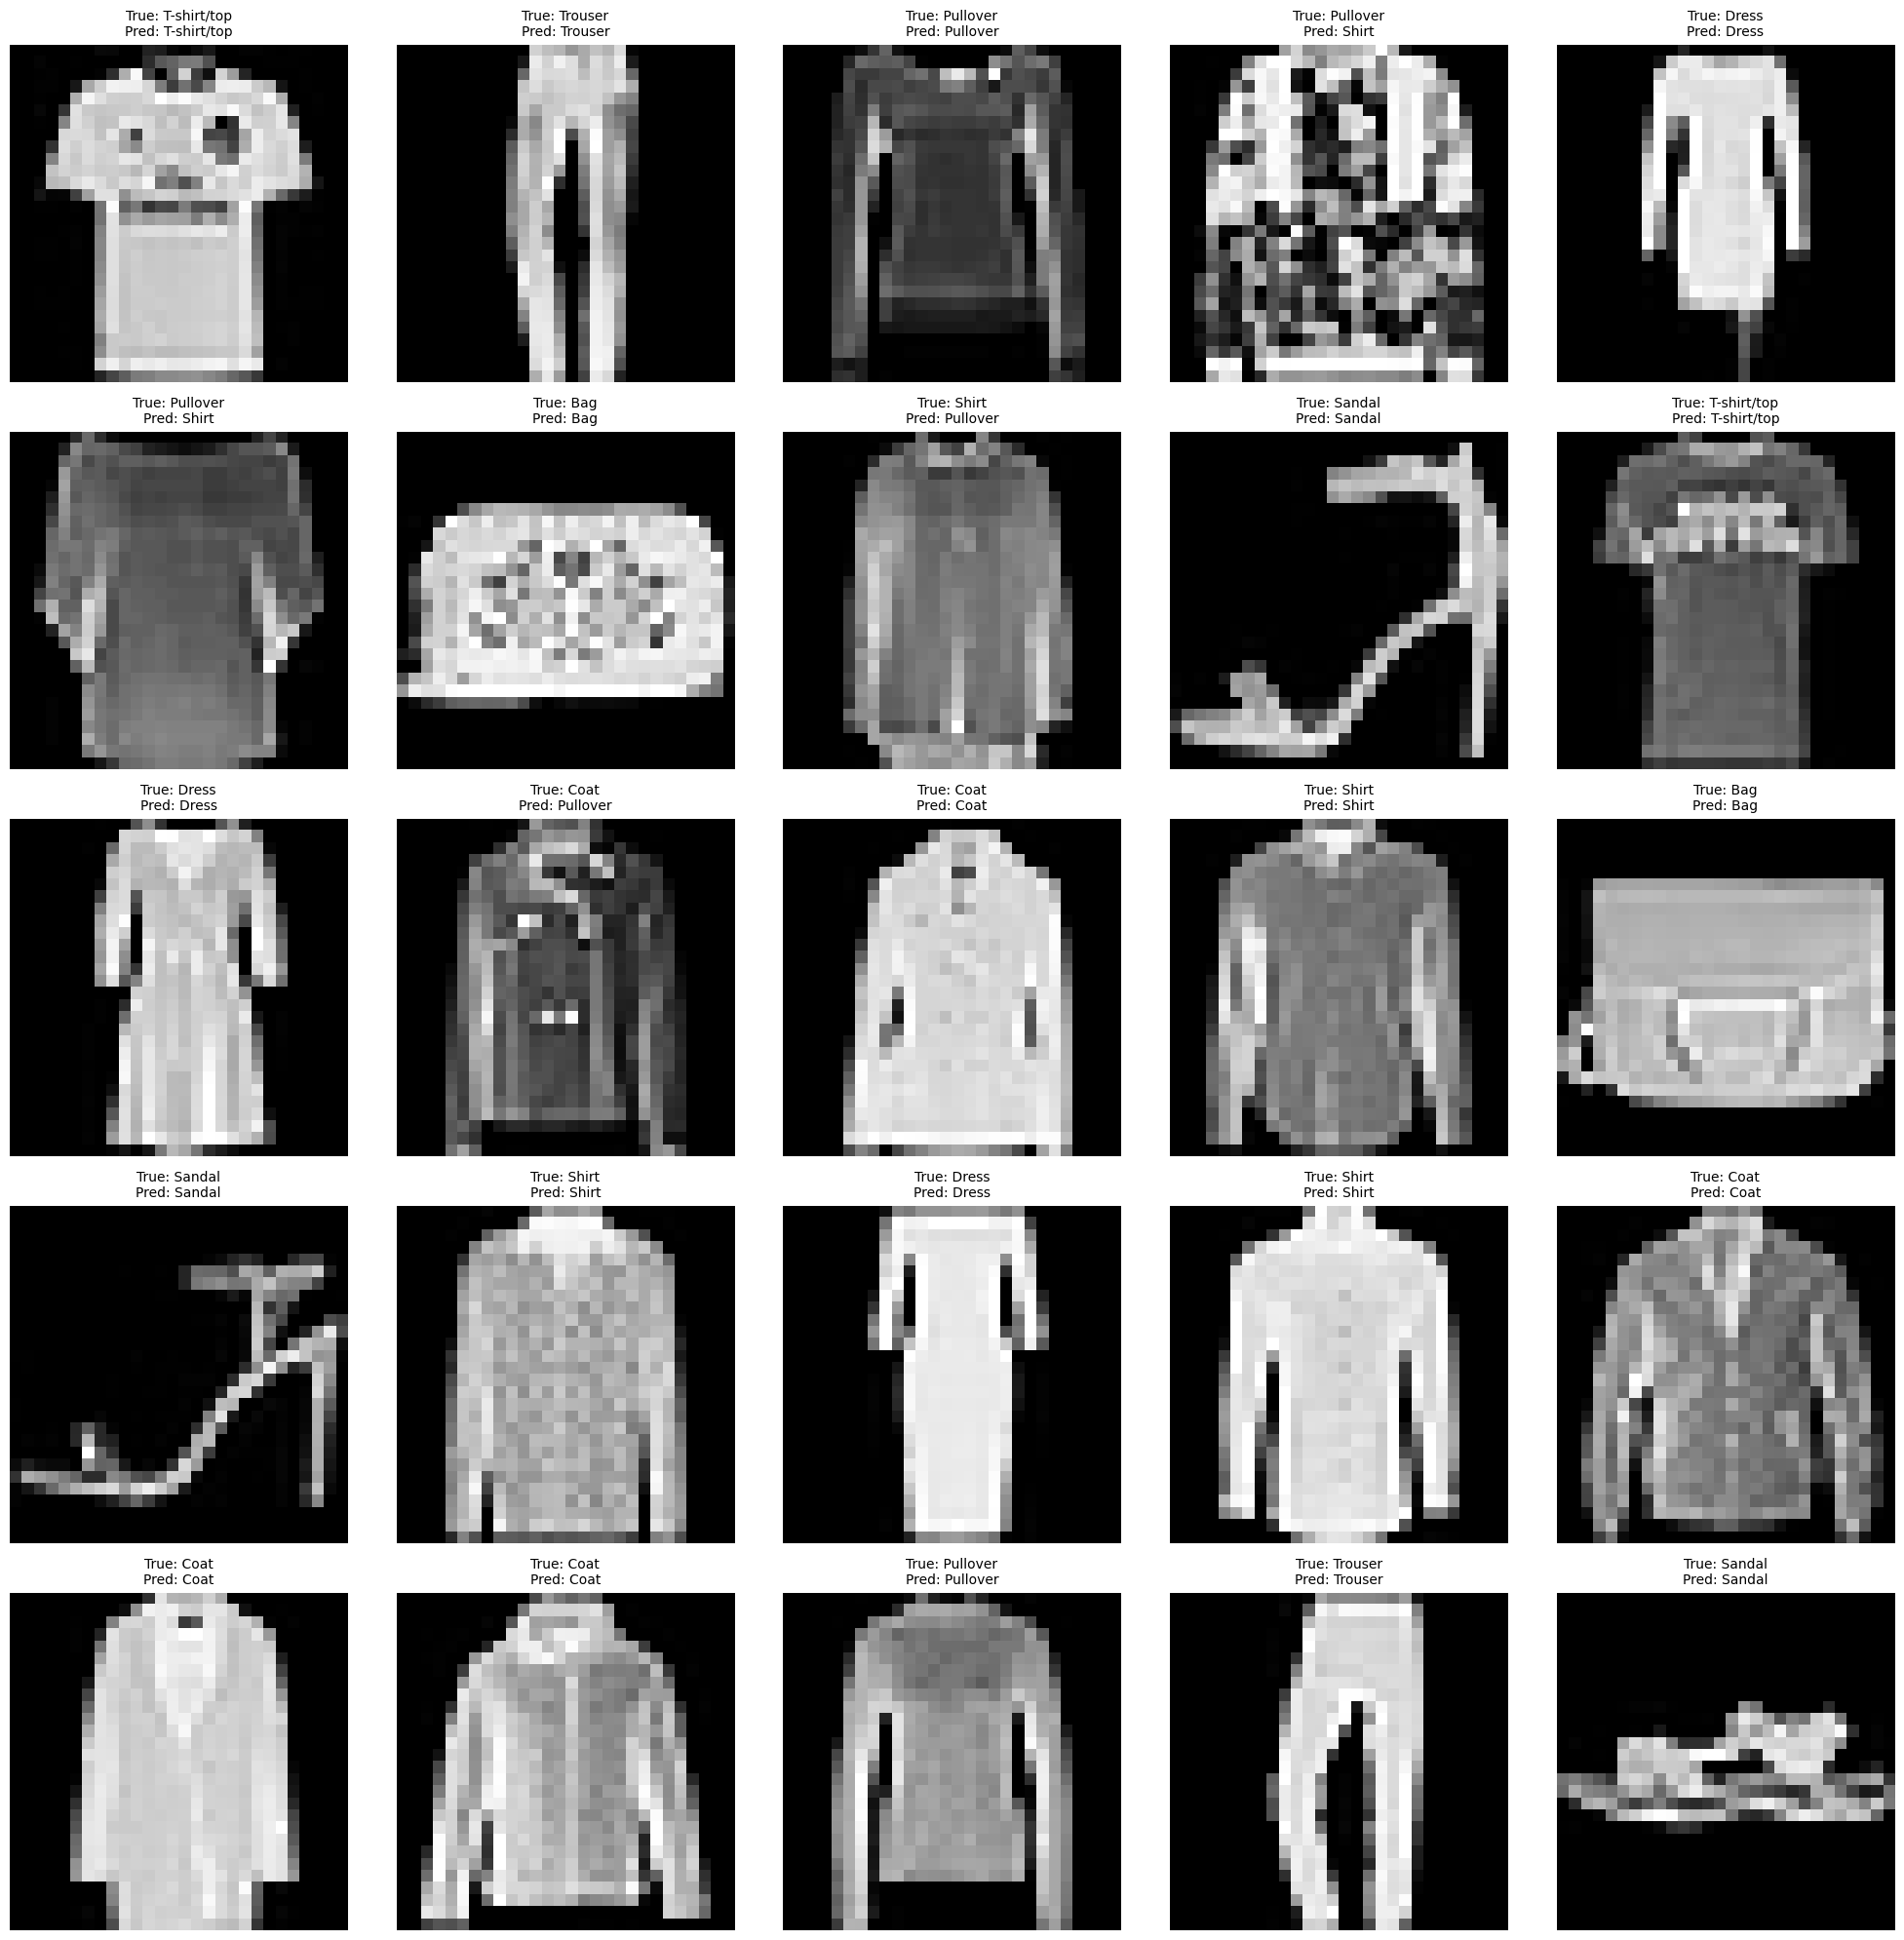

In [50]:
## to display prediction on few examples
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25):
    ax = axes[i // 5, i % 5]
    ax.imshow(test_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {class_names[test_labels[i]]}\nPred: {class_names[predicted_labels[i]]}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()





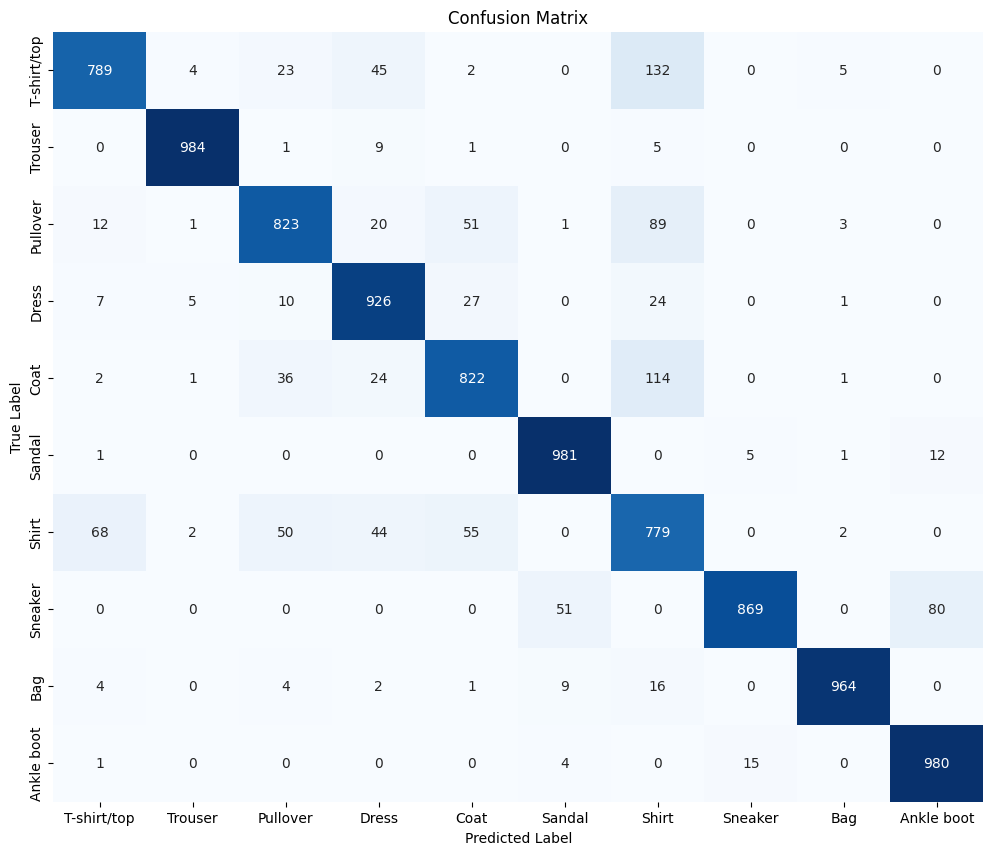

In [51]:
## to get a confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=cm_df.columns, yticklabels=cm_df.index)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
